#### <center> Keras-tuner based hyper-parameter tuning using Bayesian Optimization

Importing few of the required packages:

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline  
#will make plot outputs appear and be stored within the notebook.
import random
import tensorflow as tf
from tensorflow import keras

# plt.style.reload_library()
# plt.style.use([ 'science', 'ieee','notebook'])

import warnings
warnings.filterwarnings('ignore')

Following block will control the randomness of simulation i.e., simulation will give same results for each run as long as seed is fixed for different packages like numpy and tensorflow etc.

In [2]:
import os
SEED = 42

os.environ['PYTHONHASHSEED'] =str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

Loading dataset:

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist

#load data
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [4]:
train_images.shape

(60000, 28, 28)

In [5]:
# splitting data into train, validation and test sets
# 10% of the training dataset will be used for validation

from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(train_images, train_labels, stratify=train_labels, random_state= SEED, test_size=0.1)
(test_x, test_y)=(test_images, test_labels)

In [6]:
#normalizing pixel values to range 0-1

train_x = train_x / 255.0
val_x = val_x / 255.0
test_x = test_x / 255.0

In [7]:
train_y

array([8, 9, 8, ..., 6, 1, 9], dtype=uint8)

In [8]:
#encoding target variable

from tensorflow.keras.utils import to_categorical

train_y = to_categorical(train_y)
val_y = to_categorical(val_y)
test_y = to_categorical(test_y)

In [9]:
print(train_x.shape)  #(54000, 28, 28)
print(train_y.shape)  #(54000, 10)
print(val_x.shape)    #(6000, 28, 28)
print(val_y.shape)    #(6000, 10)
print(test_x.shape)   #(10000, 28, 28)
print(test_y.shape)   #(10000, 10)

(54000, 28, 28)
(54000, 10)
(6000, 28, 28)
(6000, 10)
(10000, 28, 28)
(10000, 10)


Neural network part:

In [10]:
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization 
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.optimizers import Adam

<!-- Hyperparameter Tuning -->

# Hyperparameter Tuning

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

In [14]:
class MyHyperModel(kt.HyperModel):
    
    def build(self, hp):

        model = Sequential()
        model.add(Flatten(input_shape=(28, 28)))

        counter = 0

        for i in range (hp.Int('num_layers', min_value = 1 , max_value = 10)):

            if counter == 0:
                model.add(Dense(
                    hp.Int('units' + str(i), min_value = 8, max_value = 128),
                    activation = hp.Choice('activation'+ str(i), values = ['relu', 'tanh', 'gelu']),
                    input_dim = 28 *28))   #only for the first layer
                model.add(Dropout(hp.Choice('dropout'+ str(i), values = [0.,0.1,0.2,0.3,0.4,0.5])))
                model.add(BatchNormalization (momentum = hp.Choice('momentum'+ str(i), values = [0.7,0.8,0.9,0.95])))
            else:
                model.add(Dense(
                    hp.Int('units' + str(i), min_value = 8, max_value = 128),
                    activation = hp.Choice('activation'+ str(i), values = ['relu', 'tanh', 'gelu'])))
                model.add(Dropout(hp.Choice('dropout'+ str(i), values = [0., 0.1,0.2,0.3,0.4,0.5])))
                model.add(BatchNormalization (momentum = hp.Choice('momentum'+ str(i), values = [0.7,0.8,0.9,0.95])))

            counter += 1

        model.add(Dense(10, activation= 'softmax'))

        model.compile(optimizer = hp.Choice('optimizer', values = ['adam', 'nadam']),
                     loss='categorical_crossentropy', metrics=['accuracy'])

        return model
    

    def fit(self, hp, model, *args, **kwargs):
        
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [8, 16, 32]),
            **kwargs,
        )

Initializing Bayesian Optimizer:

In [15]:
tuner = kt.BayesianOptimization(MyHyperModel(),
    objective="val_accuracy",
    max_trials=10,
    overwrite=True,
    alpha=0.0001,   #using default value: refer to documentation of keras tuner for more details
    beta=2.6,       #using default value: refer to documentation of keras tuner for more details
    seed=SEED,
    directory="my_dir",
    project_name="tune_hypermodel")

In [16]:
# Will stop training if the "val_acc" improves in 3 epochs

tuner.search(train_x, train_y, epochs = 10, validation_data=(val_x, val_y), callbacks=[tf.keras.callbacks.EarlyStopping("val_accuracy", mode ='max', restore_best_weights = True, patience=3)])

Trial 10 Complete [00h 11m 38s]
val_accuracy: 0.8576666712760925

Best val_accuracy So Far: 0.8778333067893982
Total elapsed time: 02h 36m 38s
INFO:tensorflow:Oracle triggered exit


In [17]:
# Get the optimal hyperparameters

best_hps=tuner.get_best_hyperparameters()[0].values
best_hps

{'num_layers': 1,
 'units0': 46,
 'activation0': 'tanh',
 'dropout0': 0.0,
 'momentum0': 0.7,
 'optimizer': 'nadam',
 'units1': 8,
 'activation1': 'relu',
 'dropout1': 0.0,
 'momentum1': 0.7,
 'units2': 8,
 'activation2': 'relu',
 'dropout2': 0.0,
 'momentum2': 0.7,
 'units3': 8,
 'activation3': 'relu',
 'dropout3': 0.0,
 'momentum3': 0.7,
 'units4': 8,
 'activation4': 'relu',
 'dropout4': 0.0,
 'momentum4': 0.7,
 'units5': 8,
 'activation5': 'relu',
 'dropout5': 0.0,
 'momentum5': 0.7,
 'units6': 8,
 'activation6': 'relu',
 'dropout6': 0.0,
 'momentum6': 0.7,
 'batch_size': 8,
 'units7': 8,
 'activation7': 'relu',
 'dropout7': 0.0,
 'momentum7': 0.7,
 'units8': 8,
 'activation8': 'relu',
 'dropout8': 0.0,
 'momentum8': 0.7,
 'units9': 8,
 'activation9': 'relu',
 'dropout9': 0.0,
 'momentum9': 0.7}

In [18]:
# tuner.results_summary()

In [19]:
tuned_model = tuner.get_best_models(num_models=1)[0]
tuned_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 46)                36110     
                                                                 
 dropout (Dropout)           (None, 46)                0         
                                                                 
 batch_normalization (BatchN  (None, 46)               184       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 10)                470       
                                                                 
Total params: 36,764
Trainable params: 36,672
Non-trainable params: 92
___________________________________________________

In [20]:
tuned_model.fit(train_x, train_y, epochs = 30, batch_size = best_hps.get('batch_size'), validation_data=(val_x, val_y), callbacks=[tf.keras.callbacks.EarlyStopping("val_accuracy", mode ='max', restore_best_weights = True, patience=3)])

Epoch 1/30
6750/6750 [==============================] - 64s 9ms/step - loss: 0.3632 - accuracy: 0.8712 - val_loss: 0.3894 - val_accuracy: 0.8748
Epoch 2/30
6750/6750 [==============================] - 59s 9ms/step - loss: 0.3633 - accuracy: 0.8721 - val_loss: 0.4376 - val_accuracy: 0.8753
Epoch 3/30
6750/6750 [==============================] - 62s 9ms/step - loss: 0.3567 - accuracy: 0.8756 - val_loss: 0.4236 - val_accuracy: 0.8690
Epoch 4/30
6750/6750 [==============================] - 61s 9ms/step - loss: 0.3528 - accuracy: 0.8759 - val_loss: 0.3481 - val_accuracy: 0.8832
Epoch 5/30
6750/6750 [==============================] - 60s 9ms/step - loss: 0.3472 - accuracy: 0.8777 - val_loss: 0.4809 - val_accuracy: 0.8805
Epoch 6/30
6750/6750 [==============================] - 61s 9ms/step - loss: 0.3430 - accuracy: 0.8784 - val_loss: 0.4484 - val_accuracy: 0.8735
Epoch 7/30
6750/6750 [==============================] - 57s 8ms/step - loss: 0.3394 - accuracy: 0.8807 - val_loss: 0.4254 - val_ac

Performance on Test Data : 

313/313 [==============================] - 1s 4ms/step - loss: 0.4187 - accuracy: 0.8663


Classification Report : 

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1000
           1       0.99      0.96      0.97      1000
           2       0.75      0.81      0.78      1000
           3       0.87      0.88      0.88      1000
           4       0.81      0.71      0.76      1000
           5       0.98      0.91      0.94      1000
           6       0.64      0.67      0.66      1000
           7       0.92      0.96      0.94      1000
           8       0.97      0.96      0.97      1000
           9       0.93      0.96      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



Confusion Matrix : 



Text(69.0, 0.5, 'Truth')

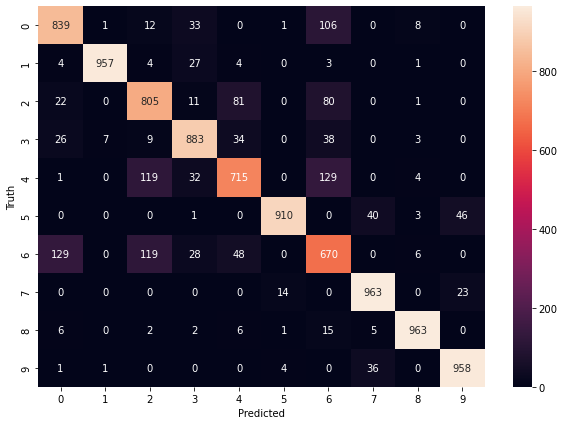

In [21]:
from sklearn.metrics import confusion_matrix , classification_report
import seaborn as sn

print('Performance on Test Data : \n')

tuned_model.evaluate(test_x, test_y)
    
y_predicted = tuned_model.predict(test_x)   ##gives values between 0 and 1

y_predicted_labels = [np.argmax(i) for i in y_predicted]   #to extract labels
y_labels = [np.argmax(i) for i in test_y]   #to extract labels    
    
cm = tf.math.confusion_matrix(labels=y_labels ,predictions=y_predicted_labels)
    
print('\n\nClassification Report : \n')
print(classification_report(y_labels ,y_predicted_labels))
    
print('\n\nConfusion Matrix : \n')
    
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

#### Sources:

[1] https://keras.io/guides/keras_tuner/getting_started/#tune-model-training

[2] https://www.youtube.com/watch?v=oYnyNLj8RMA&ab_channel=CampusX
